In [3]:
import sklearn as sk
sk.__version__

'0.24.1'

## Подключитесь к базе. Загрузите таблицы sql

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine 

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from lightgbm import LGBMClassifier
#from catboost import CatBoostClassifier
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from sklearn.base import BaseEstimator
import random
import torch.nn as nn
from torch.nn import ReLU
from math import ceil
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, confusion_matrix
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:

db_config = {
'user': 'praktikum_student', # имя пользователя,
'pwd': 'Sdf4$2;d-d30pp', # пароль,
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
'port': 6432, # порт подключения,
'db': 'data-science-vehicle-db' # название базы данных,
} 
 

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

In [6]:
engine = create_engine(connection_string) 

## Проведите первичное исследование таблиц

In [7]:
#напишем запрос
query = '''
SELECT *
FROM vehicles
LIMIT 10;
'''

vehicles = pd.read_sql_query(query, con=engine) 
vehicles

,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,1175713,5305032,2,sedan,manual,3
1,1,3858022,1,sedan,auto,3
2,1175712,5305030,1,sedan,auto,3
3,1175717,5305033,3,sedan,auto,5
4,1175722,5305034,2,sedan,auto,5
5,1175737,5305046,2,sedan,auto,5
6,1175750,5305053,3,sedan,auto,9
7,1175715,5305033,1,sedan,manual,10
8,1175716,5305033,2,sedan,manual,4
9,1175758,5305060,2,sedan,auto,11


In [8]:
vehicles['vehicle_age'].sort_values().unique()#выведем уникальные значения столбца vehicle_age таблицы vehicles

array([ 3,  4,  5,  9, 10, 11])

In [9]:
vehicles.info() #выведем общую информацию о таблице vehicles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    10 non-null     int64 
 1   case_id               10 non-null     object
 2   party_number          10 non-null     int64 
 3   vehicle_type          10 non-null     object
 4   vehicle_transmission  10 non-null     object
 5   vehicle_age           10 non-null     int64 
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


vehicles — информация о пострадавших машинах
Имеет неуникальные case_id и неуникальные party_number, которые сопоставляются с таблицей collisions и таблицей parties. Уникальный идентификатор, это case_id and party_number.

In [10]:
#напишем запрос
query = '''
SELECT *
FROM collisions
LIMIT 10;
'''

collisions = pd.read_sql_query(query, con=engine) 
collisions.head()

,case_id,county_city_location,county_location,distance,direction,intersection,weather_1,location_type,collision_damage,party_count,primary_collision_factor,pcf_violation_category,type_of_collision,motor_vehicle_involved_with,road_surface,road_condition_1,lighting,control_device,collision_date,collision_time
0,4083072,1942,los angeles,528.0,north,0,cloudy,highway,small damage,2,vehicle code violation,unsafe lane change,sideswipe,other motor vehicle,wet,normal,daylight,none,2009-01-22,07:25:00
1,4083075,4313,santa clara,0.0,None,1,clear,None,small damage,1,vehicle code violation,improper passing,hit object,fixed object,dry,normal,dark with street lights,functioning,2009-01-03,02:26:00
2,4083073,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,improper turning,broadside,other motor vehicle,dry,normal,dark with street lights,functioning,2009-01-11,03:32:00
3,4083077,0109,alameda,0.0,None,1,clear,None,scratch,2,vehicle code violation,automobile right of way,broadside,other motor vehicle,dry,normal,daylight,functioning,2009-01-11,10:35:00
4,4083087,4313,santa clara,0.0,None,1,clear,None,scratch,2,vehicle code violation,speeding,rear end,other motor vehicle,dry,None,dark with street lights,functioning,2009-01-02,22:43:00


Таблица collisions — общая информация о ДТП
Имеет уникальный case_id. Эта таблица описывает общую информацию о ДТП. Например, где оно произошло и когда.

In [11]:
collisions.info()#выведем общую информацию о таблице collisions

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   case_id                      10 non-null     object 
 1   county_city_location         10 non-null     object 
 2   county_location              10 non-null     object 
 3   distance                     10 non-null     float64
 4   direction                    4 non-null      object 
 5   intersection                 10 non-null     int64  
 6   weather_1                    10 non-null     object 
 7   location_type                5 non-null      object 
 8   collision_damage             10 non-null     object 
 9   party_count                  10 non-null     int64  
 10  primary_collision_factor     10 non-null     object 
 11  pcf_violation_category       9 non-null      object 
 12  type_of_collision            10 non-null     object 
 13  motor_vehicle_involved_

In [12]:
collisions['pcf_violation_category'].sort_values().unique()#выведем уникальные значения столбца pcf_violation_category таблицы collisions

array(['automobile right of way', 'improper passing', 'improper turning',
       'speeding', 'unsafe lane change', None], dtype=object)

In [13]:
#напишем запрос
query = '''
SELECT *
FROM parties
LIMIT 10;
'''

parties = pd.read_sql_query(query, con=engine) 
parties

,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use
0,22,3899454,1,road signs,1,29.0,had not been drinking,None,0.0
1,23,3899454,2,road signs,0,7.0,had not been drinking,None,0.0
2,29,3899462,2,car,0,21.0,had not been drinking,None,0.0
3,31,3899465,2,road signs,0,24.0,had not been drinking,None,0.0
4,41,3899478,2,road bumper,0,NaN,not applicable,not applicable,0.0
5,43,3899481,2,road bumper,0,NaN,not applicable,not applicable,0.0
6,72,3899505,2,road bumper,0,NaN,not applicable,not applicable,0.0
7,73,3899505,3,road bumper,0,NaN,not applicable,not applicable,0.0
8,76,3899509,1,road bumper,0,NaN,had not been drinking,None,0.0
9,93,3981292,2,road bumper,0,NaN,had not been drinking,None,NaN


In [14]:
parties.info()#выведем общую информацию о таблице parties

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   10 non-null     int64  
 1   case_id              10 non-null     object 
 2   party_number         10 non-null     int64  
 3   party_type           10 non-null     object 
 4   at_fault             10 non-null     int64  
 5   insurance_premium    4 non-null      float64
 6   party_sobriety       10 non-null     object 
 7   party_drug_physical  4 non-null      object 
 8   cellphone_in_use     9 non-null      float64
dtypes: float64(2), int64(3), object(4)
memory usage: 848.0+ bytes


parties — информация об участниках ДТП
Имеет неуникальный case_id, который сопоставляется с соответствующим ДТП в таблице collisions. Каждая строка здесь описывает одну из сторон, участвующих в ДТП. Если столкнулись две машины, в этой таблице должно быть две строки с совпадением case_id. Уникальный идентификатор, это case_id and party_number.

In [15]:
#напишем запрос
query = '''
SELECT *
FROM case_ids
LIMIT 10;
'''

case_ids = pd.read_sql_query(query, con=engine) 
case_ids

,case_id,db_year
0,0081715,2021
1,0726202,2021
2,3858022,2021
3,3899441,2021
4,3899442,2021
5,3899445,2021
6,3899446,2021
7,3899449,2021
8,3899450,2021
9,3899453,2021


In [16]:
case_ids.info()#выведем общую информацию о таблице case_ids

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   case_id  10 non-null     object
 1   db_year  10 non-null     object
dtypes: object(2)
memory usage: 288.0+ bytes


***Вывод***  

Проанализировали все ли таблицы, установлили, что все таблицы имеют достаточный набор данных, количество которых соответствует условию задачи.
Имеются ключи для связи таблиц.

##  Проведите статистический анализ факторов ДТП

Выясним, в какие месяцы происходит наибольшее количество аварий. Проанализируем весь период наблюдений (таблица collisions).
Создадим sql-запрос и
Построим график.




In [17]:
# напишем запрос
query_1 = '''
SELECT DISTINCT EXTRACT(month FROM collision_date) AS month_date,
                COUNT(case_id) AS count_cases
FROM collisions
GROUP BY EXTRACT(month FROM collision_date)
ORDER BY count_cases DESC
'''



In [18]:
# выполним запрос
sample_1 = pd.read_sql_query(query_1, con=engine)
#построим график 


<AxesSubplot:xlabel='month_date', ylabel='count_cases'>

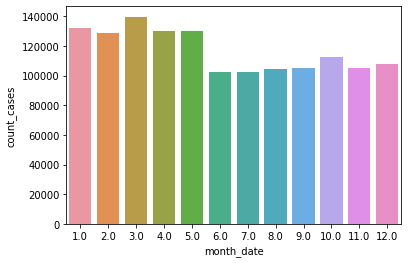

In [19]:
x = sample_1['month_date']#.value_counts().index
y = sample_1['count_cases']#.value_counts().values
sns.barplot(x, y)


Наибольшее количество аварий происходит с 1-го по 4-й месяц.

Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (связать collisions и parties);
Найдём самые частые причины ДТП (таблица parties).
2.1. Создадим шесть задач для коллег.
2.2. Пропишем порядок решения для двух задач из списка. Обязательное условие — решение этих задач должно включать связь не менее 2-х таблиц. 

1) Проведем анализ серьёзности повреждений транспортного средства, исходя из состояния дороги в момент ДТП (свяжем collisions и parties)

In [20]:
# напишем запрос
query_2 = '''
SELECT road_surface as road_surface, COUNT(collision_damage) AS count
FROM collisions
GROUP BY road_surface

'''


  road_surface    count
0          dry  1242026
1     slippery     1384
2        snowy     7261
3          wet   136236
4         None    13093


<AxesSubplot:xlabel='road_surface', ylabel='count'>

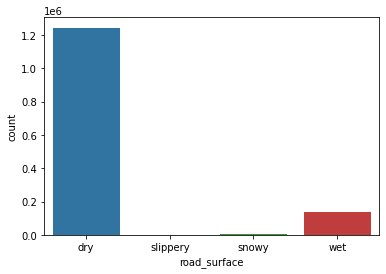

In [21]:
#выведем запрос
sample_2 = pd.read_sql_query(query_2, con=engine) 
print(sample_2)
sns_plot = sns.countplot(sample_2['count'])
fig = sns_plot.get_figure()

x = sample_2['road_surface']#.value_counts().index
y = sample_2['count']#.value_counts().values
sns.barplot(x, y)

Как видно из данных, большинство аварий происходит не из-за погодных условий.

2) Найдем самые частые причины ДТП (таблица parties).

In [22]:
# напишем запрос
query_3 = '''
SELECT party_type AS type, COUNT(case_id) AS count
FROM parties
GROUP BY party_type
ORDER BY count DESC
'''


          type    count
0          car  2469314
1  road bumper   173488
2     building    48649
3   road signs    48456
4        other     8879
5         None     3622


<AxesSubplot:xlabel='type', ylabel='count'>

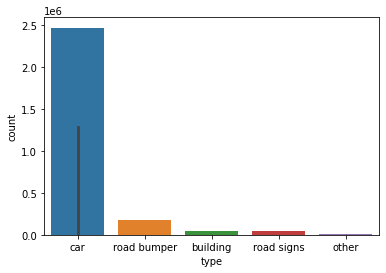

In [23]:
sample_3 = pd.read_sql_query(query_3, con=engine) 
print(sample_3)
sns_plot = sns.barplot(data = sample_3['count'])
fig = sns_plot.get_figure()

x = sample_3['type']#.value_counts().index
y = sample_3['count']#.value_counts().values
sns.barplot(x, y)


Самые частые причины ДТП это столкновение с другими машинами.

3) В какой части города было наибольшее количество пострадавших  
4) Какие повреждения были нанесены пьяными водителями  
5) В какую погоду водители признаны виновными  
6) В какую погоду нанесен наибольший страховой ущерб

#Вывод:
Проведя анализ мы установли, что самые частые причины ДТП - это столкновение с другими автомобилями, погода мало влияет на количесвто ДТП происходит в зимнее время, а также на раннюю весну (с января по апрель).

## Создайте модель для оценки водительского риска

Подготовим набор данных на основе первичного предположения заказчика:  
Выберем тип виновника — только машина (car). **  
Возьмем случаи, когда ДТП привело к любым значимым повреждениям автомобиля любого из участников — все, кроме типа SCRATCH (царапина).  
Для моделирования возьмем данные только за 2012 год.  
Подготовим исходную таблицу с помощью sql-запроса.  
Проведем первичный отбор факторов, необходимых для модели.  
Изучим описание факторов. Отобрем те, которые могут влиять на вероятность ДТП. 

In [24]:
# напишем запрос
query_model = '''
SELECT *
FROM parties p
JOIN case_ids ci ON p.case_id = ci.case_id
JOIN collisions c ON ci.case_id = c.case_id
JOIN vehicles v ON ci.case_id = v.case_id
WHERE p.party_type = 'car'
AND c.collision_damage != 'SCRATCH'
AND collision_date BETWEEN '2012-01-01' AND '2012-12-31'

'''


In [25]:
#выведем запрос
df = pd.read_sql_query(query_model, con=engine) 
df.head()


,id,case_id,party_number,party_type,at_fault,insurance_premium,party_sobriety,party_drug_physical,cellphone_in_use,case_id,...,lighting,control_device,collision_date,collision_time,id,case_id,party_number,vehicle_type,vehicle_transmission,vehicle_age
0,2407176,5455261,2,car,0,51.0,had not been drinking,None,0.0,5455261,...,daylight,functioning,2012-01-04,11:14:00,1326885,5455261,2,coupe,manual,8.0
1,2395289,5448788,1,car,0,25.0,had not been drinking,None,0.0,5448788,...,daylight,functioning,2012-01-15,16:15:00,1320256,5448788,1,sedan,manual,4.0
2,2395402,5448851,1,car,0,56.0,had not been drinking,None,0.0,5448851,...,daylight,functioning,2012-01-11,11:10:00,1320304,5448851,2,coupe,manual,2.0
3,2395402,5448851,1,car,0,56.0,had not been drinking,None,0.0,5448851,...,daylight,functioning,2012-01-11,11:10:00,1320303,5448851,1,coupe,manual,9.0
4,2405045,5454073,1,car,1,NaN,impairment unknown,G,0.0,5454073,...,daylight,none,2012-01-20,15:05:00,1325793,5454073,2,coupe,manual,3.0


In [26]:
df[[ 'primary_collision_factor', #основной фактор аварии
          'pcf_violation_category', #категория нарушения
          'type_of_collision']].head()

,primary_collision_factor,pcf_violation_category,type_of_collision
0,None,None,rear end
1,unknown,unknown,sideswipe
2,vehicle code violation,automobile right of way,broadside
3,vehicle code violation,automobile right of way,broadside
4,vehicle code violation,speeding,rear end


In [27]:
#удалим ненужные столбцы
not_in_columns=[
 'db_year', #поскольку только 2021 год   
  'county_location', #  поскольку есть похожий столбец  'county_city_location'
   'collision_date',#поскольку дата
    'id', 'case_id',
    'party_number', # Число участников происшествия, поскольку никак не влияет
    'insurance_premium', # размер страхового ущерба(понять насколько серьезные повреждения можно получить)(вторичный фактор и не влияет на то будет ли авария)
     'collision_damage', #повреждения (понять насколько серьезное ДТП)(вторичный фактор и не влияет на то будет ли авария)
          'party_count', #количество участников(понять, насколько серьезное ДТП и , возможно, пострадали еще и пассажиры)(вторичный фактор и не влияет на то будет ли авария)
           'type_of_collision',  #тип аварии(вторичный фактор и не влияет на то будет ли авария)
          'motor_vehicle_involved_with',  #дополнительные участники (вторичный фактор и не влияет на то будет ли авария)
]

In [28]:
columns =['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
          
          'at_fault', # виновность
          
          'party_drug_physical', # физическое состояние водителя(точно может влиять)
          'cellphone_in_use',  #наличие возможности разговаривать по громкой связи(влияет, не отвлекает от езды) 
          'county_city_location',  #номер географических районов, где произошло ДТП (влияетб может есть районы с боьшим количеством ДТП)
          'distance',  #расстояние от главной дороги(влияет на качество дороги, район, других участников ДТП и т.д)
          'direction', #направление(может солнце в глаза)
          'intersection', #является ли перекрестком(неправильное построение перекрестка)
          'weather_1',  #погода влияет
          'location_type',  #тип дороги (влияет на тип ДТП)
          'primary_collision_factor', #основной фактор аварии
          'pcf_violation_category', #категория нарушения
          'road_surface', #состояние дороги (погодные условия)
          'road_condition_1', #дорожное состояние(ямы и т.д.)
          'lighting',  #освещенность(влияет)
          'control_device',  #устройство управления (с автопилотом авария или без нее)      
          'collision_time',  #время влияет на освещенность, или на усталость
          'vehicle_type', #тип автомобиля
          'vehicle_transmission', #КПП
          'vehicle_age'# возраст машины влияет на ее техническое состояние
         ]

In [29]:
target = df['at_fault']
features = df[columns]
# df.drop({'at_fault', 'db_year', #поскольку только 2021 год   
#   'db_year', #поскольку только 2021 год   
#   'county_location', #  поскольку есть похожий столбец  'county_city_location'
#    'collision_date',#поскольку дата
#     'id', 'case_id',
#     'party_number', # Число участников происшествия, поскольку никак не влияет
#     'insurance_premium', # размер страхового ущерба(понять насколько серьезные повреждения можно получить)(вторичный фактор и не влияет на то будет ли авария)
#      'collision_damage', #повреждения (понять насколько серьезное ДТП)(вторичный фактор и не влияет на то будет ли авария)
#           'party_count', #количество участников(понять, насколько серьезное ДТП и , возможно, пострадали еще и пассажиры)(вторичный фактор и не влияет на то будет ли авария)
#            'type_of_collision',  #тип аварии(вторичный фактор и не влияет на то будет ли авария)
#           'motor_vehicle_involved_with'  #дополнительные участники (вторичный фактор и не влияет на то будет ли авария)}, axis=1)
# })


In [30]:
df[['party_type',     # Тип участника происшествия. Таблица parties
          'party_sobriety', # Уровень трезвости виновника (точно может влиять) Таблица parties
          
          'at_fault', # виновность
          
          'party_drug_physical', # физическое состояние водителя(точно может влиять)
          'cellphone_in_use',  #наличие возможности разговаривать по громкой связи(влияет, не отвлекает от езды) 
          'county_city_location',  #номер географических районов, где произошло ДТП (влияетб может есть районы с боьшим количеством ДТП)
          'distance',  #расстояние от главной дороги(влияет на качество дороги, район, других участников ДТП и т.д)
          'direction', #направление(может солнце в глаза)
          'intersection', #является ли перекрестком(неправильное построение перекрестка)
          'weather_1',  #погода влияет
          'location_type',  #тип дороги (влияет на тип ДТП)
          'primary_collision_factor', #основной фактор аварии
          'pcf_violation_category', #категория нарушения
          'road_surface', #состояние дороги (погодные условия)
          'road_condition_1', #дорожное состояние(ямы и т.д.)
          'lighting',  #освещенность(влияет)
          'control_device',  #устройство управления (с автопилотом авария или без нее)      
          'collision_time',  #время влияет на освещенность, или на усталость
          'vehicle_type', #тип автомобиля
          'vehicle_transmission', #КПП
          'vehicle_age'# возраст машины влияет на ее техническое состояние
         ]].head()

,party_type,party_sobriety,at_fault,party_drug_physical,cellphone_in_use,county_city_location,distance,direction,intersection,weather_1,...,primary_collision_factor,pcf_violation_category,road_surface,road_condition_1,lighting,control_device,collision_time,vehicle_type,vehicle_transmission,vehicle_age
0,car,had not been drinking,0,None,0.0,3001,98.0,east,0.0,clear,...,None,None,dry,normal,daylight,functioning,11:14:00,coupe,manual,8.0
1,car,had not been drinking,0,None,0.0,0900,200.0,north,0.0,clear,...,unknown,unknown,dry,normal,daylight,functioning,16:15:00,sedan,manual,4.0
2,car,had not been drinking,0,None,0.0,0800,0.0,None,1.0,clear,...,vehicle code violation,automobile right of way,dry,normal,daylight,functioning,11:10:00,coupe,manual,2.0
3,car,had not been drinking,0,None,0.0,0800,0.0,None,1.0,clear,...,vehicle code violation,automobile right of way,dry,normal,daylight,functioning,11:10:00,coupe,manual,9.0
4,car,impairment unknown,1,G,0.0,3313,2000.0,east,0.0,clear,...,vehicle code violation,speeding,dry,normal,daylight,none,15:05:00,coupe,manual,3.0


In [31]:
df['party_sobriety'].sort_values().unique()

array(['had been drinking, impairment unknown',
       'had been drinking, not under influence',
       'had been drinking, under influence', 'had not been drinking',
       'impairment unknown', 'not applicable', None], dtype=object)

<AxesSubplot:xlabel='party_sobriety', ylabel='count'>

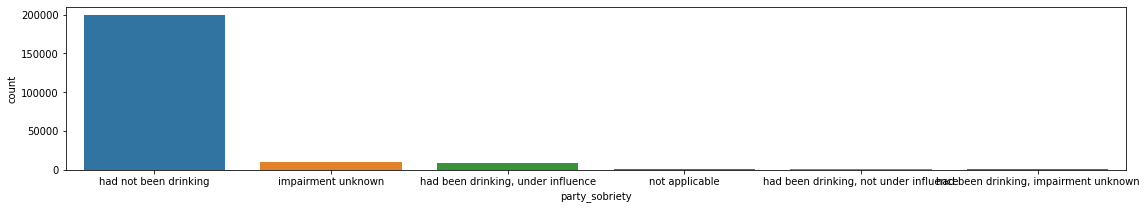

In [32]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'party_sobriety', data = df)

In [33]:
#Поскольку наибольшее влияние оказывает фактор had_been_drinking, оставим его, а остальные факторы добавим в категорию other
counts = df.groupby('party_sobriety')['at_fault'].count()
display(counts.describe())
country_count = df.groupby('party_sobriety')['at_fault'].transform("count")
df['party_sobriety'] = df['party_sobriety'].where(country_count > 5000, "Other")
display(df['party_sobriety'])

count         6.000000
mean      37073.000000
std       79870.543013
min         859.000000
25%        1456.250000
50%        5031.500000
75%        9770.000000
max      199902.000000
Name: at_fault, dtype: float64

0                      had not been drinking
1                      had not been drinking
2                      had not been drinking
3                      had not been drinking
4                         impairment unknown
                         ...                
225773    had been drinking, under influence
225774    had been drinking, under influence
225775                 had not been drinking
225776                 had not been drinking
225777                                 Other
Name: party_sobriety, Length: 225778, dtype: object

In [34]:
df['party_drug_physical'].sort_values().unique()

array(['G', 'impairment - physical', 'not applicable', 'sleepy/fatigued',
       'under drug influence', None], dtype=object)

<AxesSubplot:xlabel='party_drug_physical', ylabel='count'>

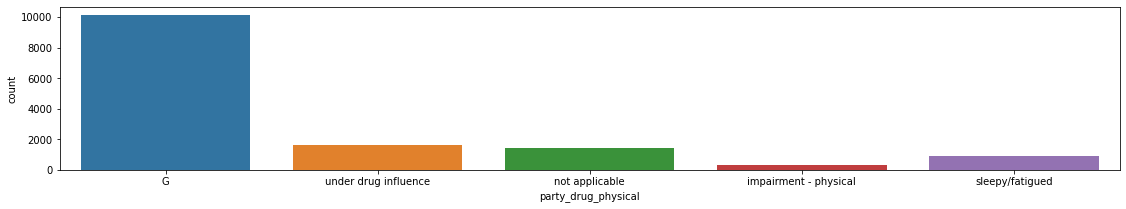

In [35]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'party_drug_physical', data = df)

In [36]:
#Поскольку наибольшее влияние оказывает фактор G, оставим его, а остальные факторы добавим в категорию other
counts = df.groupby('party_drug_physical')['at_fault'].count()
display(counts.describe())
country_count = df.groupby('party_drug_physical')['at_fault'].transform("count")
df['party_drug_physical'] = df['party_drug_physical'].where(country_count > 930, "Other")
display(df['party_drug_physical'])

count        5.000000
mean      2900.800000
std       4091.951637
min        316.000000
25%        913.000000
50%       1453.000000
75%       1661.000000
max      10161.000000
Name: at_fault, dtype: float64

0                  Other
1                  Other
2                  Other
3                  Other
4                      G
               ...      
225773             Other
225774             Other
225775             Other
225776             Other
225777    not applicable
Name: party_drug_physical, Length: 225778, dtype: object

In [37]:
df['insurance_premium'].sort_values().unique()

array([  0.,   2.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,
        13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,
        24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,
        35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,
        46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,
        57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,
        68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,
        79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,
        90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100.,
       101., 102., 103., 104., 105.,  nan])

In [38]:
df['cellphone_in_use'].sort_values().unique()

array([ 0.,  1., nan])

In [39]:
df['county_city_location'].sort_values().unique()

array(['0100', '0101', '0102', '0103', '0104', '0105', '0106', '0107',
       '0108', '0109', '0110', '0111', '0112', '0113', '0198', '0200',
       '0300', '0301', '0302', '0303', '0304', '0305', '0400', '0401',
       '0402', '0403', '0404', '0405', '0500', '0501', '0600', '0601',
       '0602', '0700', '0701', '0702', '0703', '0704', '0705', '0706',
       '0707', '0708', '0709', '0710', '0711', '0712', '0714', '0715',
       '0716', '0734', '0790', '0791', '0792', '0800', '0801', '0900',
       '0901', '0902', '1000', '1001', '1002', '1004', '1005', '1007',
       '1008', '1011', '1012', '1013', '1015', '1100', '1101', '1102',
       '1200', '1201', '1203', '1205', '1300', '1301', '1302', '1304',
       '1305', '1306', '1400', '1401', '1500', '1501', '1502', '1503',
       '1504', '1505', '1506', '1507', '1508', '1509', '1510', '1511',
       '1515', '1600', '1601', '1602', '1603', '1690', '1700', '1701',
       '1702', '1800', '1801', '1900', '1901', '1902', '1903', '1905',
      

In [40]:
df['distance'].sort_values().unique()

array([0.00000e+00, 1.00000e+00, 1.10000e+00, ..., 1.51008e+05,
       1.71600e+05, 1.58400e+06])

In [41]:
df['direction'].sort_values().unique()

array(['east', 'north', 'south', 'west', None], dtype=object)

<AxesSubplot:xlabel='direction', ylabel='count'>

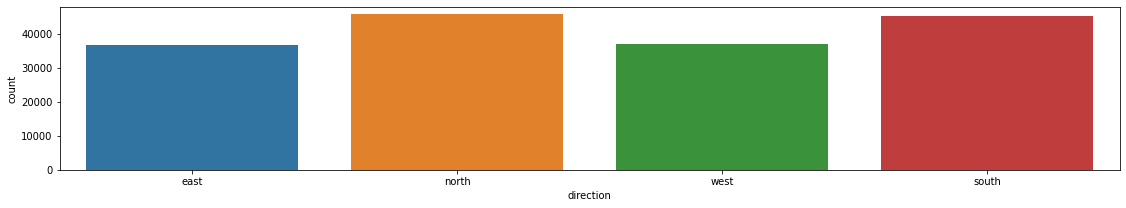

In [42]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'direction', data = df)

In [43]:
df['intersection'].sort_values().unique()

array([ 0.,  1., nan])

In [44]:
df['weather_1'].sort_values().unique()

array(['clear', 'cloudy', 'fog', 'other', 'raining', 'snowing', 'wind',
       None], dtype=object)

Как видно из данных, insurance_premium', 'cellphone_in_use', 'county_city_location', 'distance', 'direction', 'intersection' и 'weather_1' не содержат некорректных и аномальных данных.

In [45]:
df['location_type'].sort_values().unique()

array(['highway', 'intersection', 'ramp', None], dtype=object)

<AxesSubplot:xlabel='location_type', ylabel='count'>

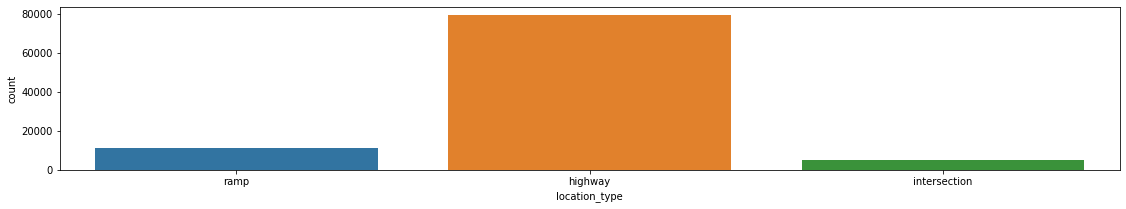

In [46]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'location_type', data = df)

In [47]:
#Поскольку наибольшее влияние оказывает фактор highway, оставим его, а остальные факторы добавим в категорию other
counts = df.groupby('location_type')['at_fault'].count()
display(counts.describe())
country_count = df.groupby('location_type')['at_fault'].transform("count")
df['location_type'] = df['location_type'].where(country_count > 930, "Other")
display(df['location_type'])

count        3.000000
mean     31997.666667
std      41380.128593
min       5008.000000
25%       8177.000000
50%      11346.000000
75%      45492.500000
max      79639.000000
Name: at_fault, dtype: float64

0           Other
1           Other
2            ramp
3            ramp
4         highway
           ...   
225773      Other
225774      Other
225775      Other
225776      Other
225777      Other
Name: location_type, Length: 225778, dtype: object

In [48]:
df['collision_damage'].sort_values().unique()

array(['fatal', 'middle damage', 'scratch', 'severe damage',
       'small damage'], dtype=object)

<AxesSubplot:xlabel='collision_damage', ylabel='count'>

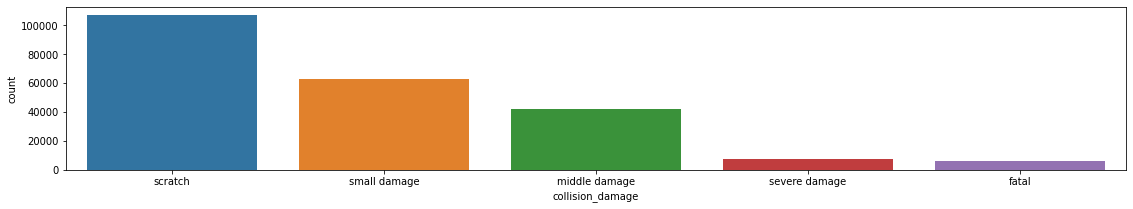

In [49]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'collision_damage', data = df)

In [50]:
df['primary_collision_factor'].sort_values().unique()

array(['fell asleep', 'other improper driving', 'other than driver',
       'unknown', 'vehicle code violation', None], dtype=object)

<AxesSubplot:xlabel='primary_collision_factor', ylabel='count'>

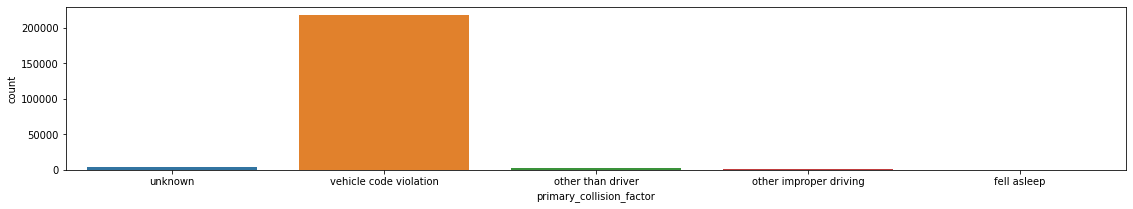

In [51]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'primary_collision_factor', data = df)

In [52]:
counts = df.groupby('primary_collision_factor')['at_fault'].count()
display(counts.describe())
country_count = df.groupby('primary_collision_factor')['at_fault'].transform("count")
df['primary_collision_factor'] = df['primary_collision_factor'].where(country_count > 150000, "Other")
display(df['primary_collision_factor'])

count         5.000000
mean      45027.600000
std       96954.469238
min           3.000000
25%         765.000000
50%        2486.000000
75%        3436.000000
max      218448.000000
Name: at_fault, dtype: float64

0                          Other
1                          Other
2         vehicle code violation
3         vehicle code violation
4         vehicle code violation
                   ...          
225773    vehicle code violation
225774    vehicle code violation
225775    vehicle code violation
225776    vehicle code violation
225777    vehicle code violation
Name: primary_collision_factor, Length: 225778, dtype: object

In [53]:
len(df['pcf_violation_category'].sort_values().unique())

23

<AxesSubplot:xlabel='pcf_violation_category', ylabel='count'>

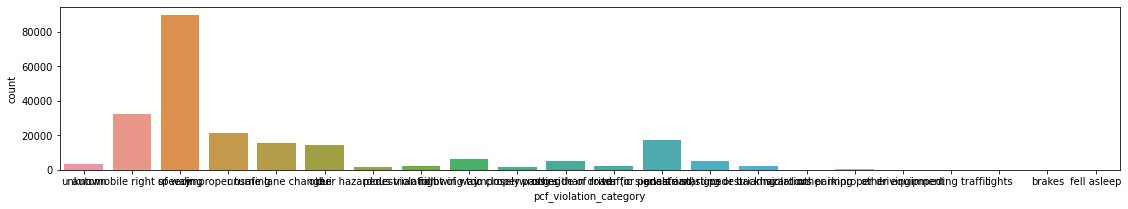

In [54]:
plt.figure(figsize=(19,3))
sns.countplot(x = 'pcf_violation_category', data = df)

In [55]:
df['pcf_violation_category'].describe()

count       222370
unique          22
top       speeding
freq         89998
Name: pcf_violation_category, dtype: object

In [56]:
#Поскольку факторов очень много , оставим тольк те, которые с наибольшими значениями, а остальные факторы добавим в категорию other
counts = df.groupby('pcf_violation_category')['at_fault'].count()
display(counts.describe())
country_count = df.groupby('pcf_violation_category')['at_fault'].transform("count")
df['pcf_violation_category'] = df['pcf_violation_category'].where(country_count > 2400, "Other")
display(df['pcf_violation_category'])


count       22.000000
mean     10107.727273
std      19804.381514
min          3.000000
25%        342.000000
50%       2363.000000
75%      12550.750000
max      89998.000000
Name: at_fault, dtype: float64

0                           Other
1                         unknown
2         automobile right of way
3         automobile right of way
4                        speeding
                   ...           
225773                        dui
225774                        dui
225775                      Other
225776                      Other
225777                      Other
Name: pcf_violation_category, Length: 225778, dtype: object

In [57]:
len(df['pcf_violation_category'].sort_values().unique())

12

In [58]:
df['type_of_collision'].sort_values().unique()

array(['broadside', 'head-on', 'hit object', 'other', 'overturned',
       'rear end', 'sideswipe', None], dtype=object)

In [59]:
df['motor_vehicle_involved_with'].sort_values().unique()

array(['animal', 'bicycle', 'fixed object',
       'motor vehicle on other roadway', 'non-collision',
       'other motor vehicle', 'other object', 'parked motor vehicle',
       'train', None], dtype=object)

In [60]:
df['road_condition_1'].sort_values().unique()

array(['construction', 'flooded', 'holes', 'loose material', 'normal',
       'obstruction', 'other', 'reduced width', None], dtype=object)

In [61]:
df['lighting'].sort_values().unique()

array(['dark with no street lights', 'dark with street lights',
       'dark with street lights not functioning', 'daylight',
       'dusk or dawn', None], dtype=object)

In [62]:
df['control_device'].sort_values().unique()

array(['functioning', 'none', 'not functioning', 'obscured', None],
      dtype=object)

In [63]:
df['vehicle_type'].sort_values().unique()

array(['coupe', 'hatchback', 'minivan', 'other', 'sedan'], dtype=object)

In [64]:
df['vehicle_transmission'].sort_values().unique()

array(['auto', 'manual', None], dtype=object)

В столбцах type_of_collision, vehicle_transmission, vehicle_type, control_device, lighting, road_condition_1, motor_vehicle_involved_with аномальных и некорректных значений не выявлено.

In [65]:
df['vehicle_age'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  19., 161.,  nan])

<AxesSubplot:xlabel='vehicle_age', ylabel='count'>

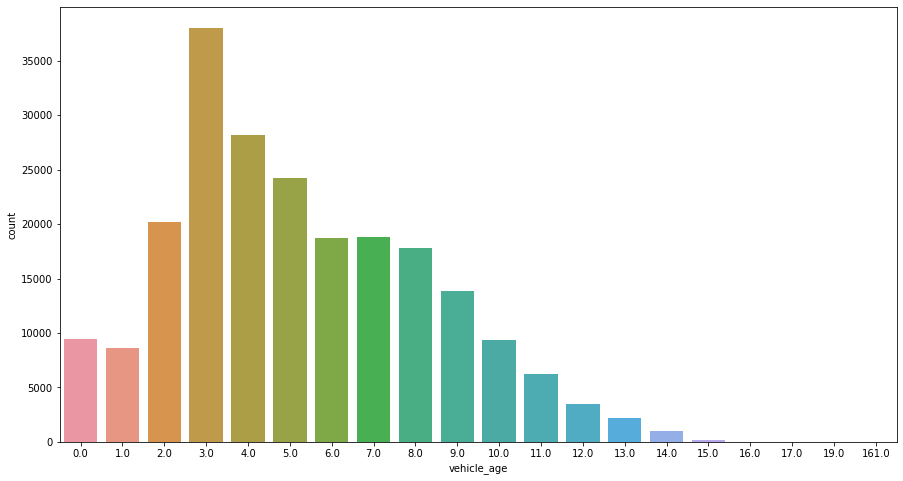

In [66]:

plt.figure(figsize=(15,8))
sns.countplot(x = 'vehicle_age', data = df)


***Вывод:***  
Провели первичную предобработку данных.

In [67]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

In [68]:
#определим категориальные и числовые столбцы
cat_features = ['party_type', 'party_sobriety', 'party_drug_physical', 'direction', 
                'weather_1', 'location_type', 'primary_collision_factor', 
                'pcf_violation_category', 'lighting', 'control_device',
                'vehicle_type', 'road_surface',  'vehicle_transmission',
               'road_condition_1', 'county_city_location']
num_features = ['cellphone_in_use', 'distance', 
       'intersection', 
       'vehicle_age']


In [69]:
X_train[num_features].head()

,cellphone_in_use,distance,intersection,vehicle_age
84794,NaN,20.0,0.0,8.0
66502,0.0,503.0,0.0,5.0
34029,0.0,248.0,0.0,4.0
67353,0.0,20.0,0.0,7.0
8388,NaN,15.0,0.0,5.0


In [70]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train[num_features])
X_train[num_features] = imputer.transform(X_train[num_features])
X_test[num_features] = imputer.transform(X_test[num_features])


/tmp/ipykernel_31/1334030493.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[num_features] = imputer.transform(X_train[num_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/1334030493.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [71]:
imputer = SimpleImputer(strategy='constant')
imputer.fit(X_train[cat_features])
X_train[cat_features] = imputer.transform(X_train[cat_features])
X_test[cat_features] = imputer.transform(X_test[cat_features])

/tmp/ipykernel_31/4227118737.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[cat_features] = imputer.transform(X_train[cat_features])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/4227118737.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [72]:
num_transformer_linear = make_pipeline(StandardScaler())
cat_transformer_linear = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))


preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer_linear, num_features),
        ("cat", cat_transformer_linear, cat_features)
    ]
)


In [73]:
import sklearn as sk
sk.__version__

'0.24.1'

In [74]:
def best_classifier(names, classifiers, parameters, X, y, X_hold_out, y_hold_out):
    """
    """
    
    result = []
    model_fitted = []
    predictions = []
    best_params = []

#Начинаем перебирать параметры через гридсечр    
    for name, classifier, hyperparam in zip(names, classifiers, parameters):
    
        clf = Pipeline(steps=[('preprocessor', preprocessor),('classifier', classifier)])
        print(f"Fitting model {name}")
        model = GridSearchCV(estimator=clf, param_grid = hyperparam, cv=5, scoring='roc_auc', n_jobs = -1, verbose = 0).fit(X, y)
    
        auc_roc_valid = model.best_score_
 
        model_fitted.append(model)
        
#вычисяем предсказания и метрики
        predicted_test = model.best_estimator_.predict(X_hold_out)
        probabilities_test = model.best_estimator_.predict_proba(X_hold_out)
        probabilities_one_test = probabilities_test[:, 1]
        auc_roc = roc_auc_score(y_test, probabilities_one_test)
        accuracy = accuracy_score(y_hold_out, predicted_test)
        
        precision = precision_score(y_hold_out, predicted_test)
        recall = recall_score(y_hold_out, predicted_test)
        f1 = f1_score(y_hold_out, predicted_test)
        
#Сохраняем метрики и параметры лучших моделей в result    
        result.append([accuracy, auc_roc_valid, auc_roc, precision, recall, f1, name, model.best_params_])
        best_params.append(model.best_params_)
#Сохраняем предсказания в predictions
        predictions.append(predicted_test)
    result = pd.DataFrame(result, columns = ['accuracy', 'auc_roc_valid', 'auc_roc', 'precision', 'recall', 'f1', 'name', 'model.best_params_']) 
    
    try:
        display(result.sort_values(by = 'auc_roc', ascending = False))
    except:
        import traceback
        traceback.print_exc()
    return result, model_fitted, predictions, best_params

In [75]:
current_names = ['RandomForestClassifier', 'LGBMClassifier']
current_classifiers = [RandomForestClassifier(random_state=1), LGBMClassifier(random_state=1)]
current_params = [[{'classifier__n_estimators': range(1, 2, 10), 'classifier__max_depth': range(1, 2, 10)}],
                  [{'classifier__learning_rate':(0.00007,0.00005),
                    'classifier__n_estimators': range(1, 2, 10)}]]

result = best_classifier(current_names, current_classifiers, current_params, X_train, y_train, X_test, y_test)
result_rfc, model_fitted_rfc, predictions_rfc, best_params_rfc = result

Fitting model RandomForestClassifier


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Fitting model LGBMClassifier


/opt/conda/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,auc_roc_valid,auc_roc,precision,recall,f1,name,model.best_params_
1,0.54562,0.688356,0.683717,0.0,0.0,0.0,LGBMClassifier,"{'classifier__learning_rate': 7e-05, 'classifi..."
0,0.54562,0.525433,0.509661,0.0,0.0,0.0,RandomForestClassifier,"{'classifier__max_depth': 1, 'classifier__n_es..."


Для проекта выбрала метрику accuracy, потому что accuracy это доля объектов, для которых мы правильно предсказали класс. Это метрика, которая характеризует качество модели, агрегированное по всем классам. Мы всю сложную структуру ошибок свели к одному числу, т.к. на вещественных числах отношение порядка есть. 

In [ ]:
result_rfc['score'] = result_rfc['accuracy']
result_rfc['param'] = result_rfc['name']
result_rfc

In [ ]:
res_best = result_rfc[[ 'param', "score"]]
res_best

In [ ]:
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep = preprocessor.transform(X_test)

In [ ]:
#преобразуем выборки в массив numpy
# X_train_prep = X_train_prep.toarray()
# X_test_prep = X_test_prep.toarray()
y_train_prep = np.array(y_train.values)
y_test_prep = np.array(y_test.values)


In [ ]:
#определеим количество входных нейров
features_count = X_train_prep.shape[1]
# преобразуем выборки в тензор из массива numpy
X_train_prep = torch.from_numpy(X_train_prep).float()
X_test_prep = torch.from_numpy(X_test_prep).float()
y_test_prep = torch.from_numpy(y_test_prep).float()
y_train_prep = torch.from_numpy(y_train_prep).float()


In [ ]:
# определим параметры для подбора 
rs = np.random.RandomState(0)
grid = {
    "n_neurons_in":[features_count],
    'n_neurons_out':[1],
    'n_hidden_1':[150, 200],
    'n_hidden_2':[15, 20],
    'activation_1':[nn.ReLU(), nn.LeakyReLU()],
    'activation_2':[nn.ReLU(), nn.LeakyReLU()],
    'activation_out': [nn.Sigmoid()],
    'regularization':['batch_norm', 'dropout'],
    'batch_size':[150, 140],
    'learning_rate':[0.0005,  0.0000007]
     
}

parameter_list = list(ParameterSampler(grid, n_iter=3, random_state=rs))



In [ ]:
num_epochs = 2
results = {}
best_score_overall = 1e+100000


In [ ]:
#напишим метод, который будет инициализировать слой
def init_weights(layer):
    if type(layer) == nn.Linear:
        nn.init.normal_(layer.weight, mean=0, std=np.sqrt(2/layer.in_features))
        nn.init.normal_(layer.bias, mean=0, std=0)
        

In [ ]:
for i, param in enumerate(parameter_list):
    best_param = 1e+100000
    
    net_layers =[]
    net_layers.append(nn.Linear(param['n_neurons_in'], param['n_hidden_1']))
    if param['regularization'] =='dropout':
        net_layers.append(nn.Dropout(p=0.5))
    elif param['regularization'] =='batch_norm':
        net_layers.append(nn.BatchNorm1d(param['n_hidden_1']))
    if param['activation_1'] is not ReLU():
        net_layers.append(param['activation_1'])
    net_layers.append(nn.Linear(param['n_hidden_1'], param['n_hidden_2']))
        

    if param['regularization'] =='dropout':
        net_layers.append(nn.Dropout(p=0.5))
    elif param['regularization'] =='batch_norm':
        net_layers.append(nn.BatchNorm1d(param['n_hidden_2']))
    if param['activation_2'] is not ReLU():
        net_layers.append(param['activation_2'])
       
    net_layers.append(nn.Linear(param['n_hidden_2'], param['n_neurons_out']))
    if param['activation_out'] is not ReLU():
        net_layers.append(param['activation_out'])
        
    net = nn.Sequential(*net_layers) # такая запись позволяет передавать элементы списка как параметры для инициализации
    net.apply(init_weights) #применим метод ко всем слоям сети
    optimizer = torch.optim.Adam(net.parameters(),lr=0.2)
    loss = nn.BCELoss()
    train_data = TensorDataset(X_train_prep, y_train_prep)
    train_loader = DataLoader(dataset = train_data, batch_size=param['batch_size'], shuffle=True)
    for _ in range(num_epochs):
        for i_batch, batch in enumerate(train_loader):
            X_batch, y_batch = batch
            preds_batch = net.forward(X_batch)
            loss_value = loss(preds_batch.reshape(-1,), y_batch)
            optimizer.zero_grad() 
            loss_value.backward()            
            optimizer.step()
        
            if i_batch % 20 ==0 or i_batch ==i_batch-1:
                net.eval()
                test_preds = net.forward(X_test_prep)
                accuracy = (test_preds.argmax(dim=1) == y_test_prep).float().mean().data
               
            

                is_best_overall = accuracy < best_score_overall
                best_score_overall = min(accuracy, best_score_overall)
                
                is_best_param = accuracy < best_param
                best_param = min(accuracy, best_param)
                
                if is_best_overall:
                    torch.save(net, 'best_model.pth')
                

                if is_best_param:
                    results[i] = (param, best_param)
                

In [ ]:
#выведем результат
results_df = pd.DataFrame.from_dict(results, orient='index')
params = results_df[0].apply(pd.Series).drop(columns={'n_neurons_out', 'n_neurons_in'}, axis=1)
params['mean_test_score'] = results_df[1]
results_df = params.sort_values(by='mean_test_score')
results_df.head()

In [ ]:
#добавим столбце с названием модели
results_df['param'] =  ['neuron' for i in range(len(results_df['mean_test_score']))]
results_df['score']=results_df['mean_test_score']

In [ ]:
#оставим только определенные столбцы и только самое лучшее значение
results_df_best = results_df[['param', 'score']]
results_df_best = results_df_best.head(1)
results_df_best

In [ ]:
#Выведем таблицу со значениями разных моделей
models = pd.concat([res_best, results_df_best]).reset_index()
del models['index']
models

Таким образом, лучшая модель - RandomForestClassifier

## Проведите анализ важности факторов ДТП

In [ ]:
# print(y_test.shape)
confusion_matrix(y_test, predictions_rfc[0])

Как видно из данных, в 30532 случаях модель RandomForestClassifier выдает истинно позитивное предсказание (True Positive), в 22 183 случаях модель выдает ошибочно положительное предсказание (False Positive).

Проведем анализ важности фаткоров feature_importances_

In [ ]:
# feature_names = preprocessor.fit(X_train).get_feature_names_out()

In [ ]:
# print(model_fitted_rfc[1].best_estimator_[1])

In [ ]:
# feature_importances_lgbm = model_fitted_rfc[1].best_estimator_[1].feature_importances_
# feature_importances_rf = model_fitted_rfc[1].best_estimator_[1].feature_importances_

Выведем наиболее важные факторы для модели LGBMClassifier

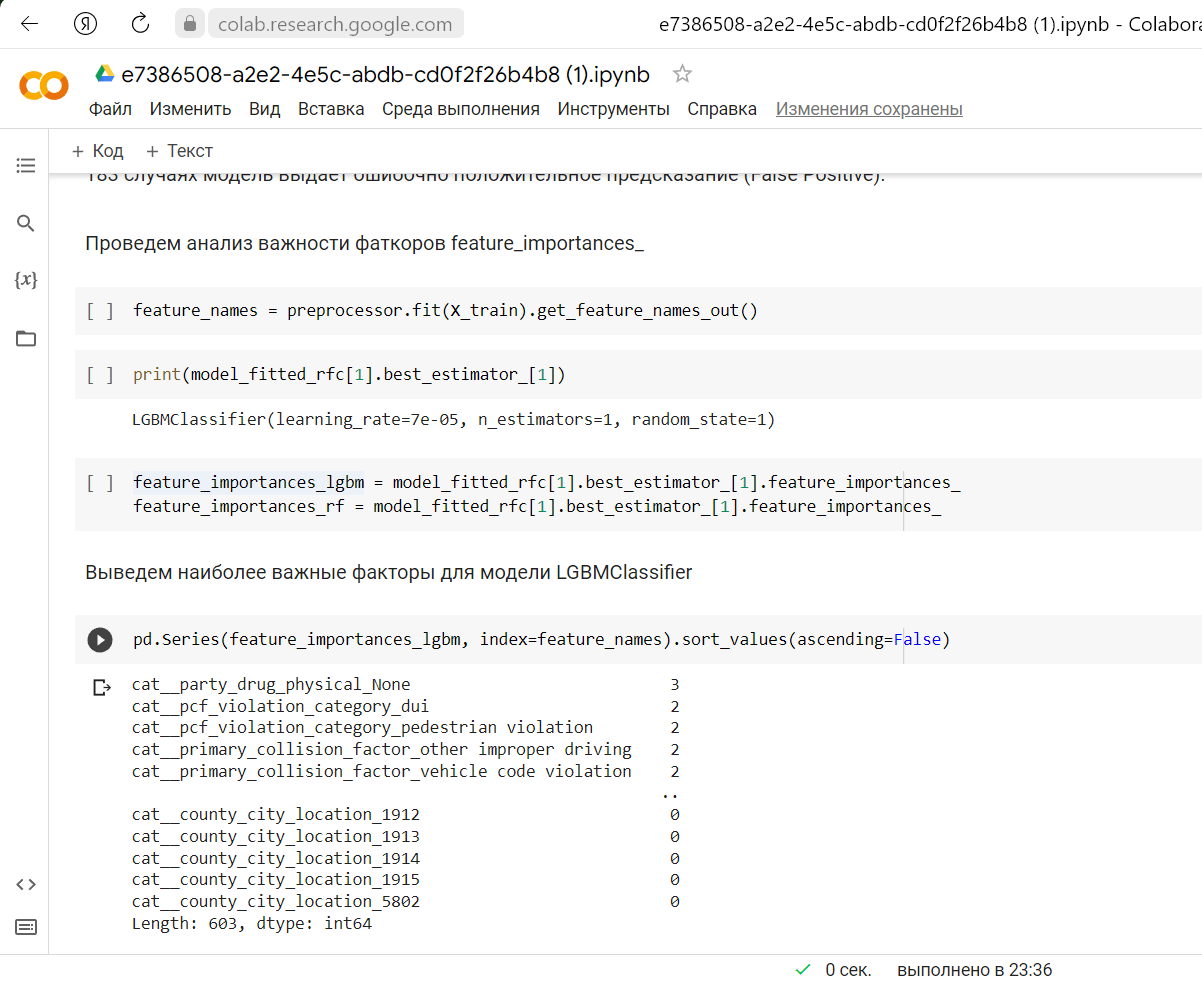

In [4]:
from IPython.display import Image
Image(filename='2022-07-09_10-57-31.png')

In [ ]:
# pd.Series(feature_importances_lgbm, index=feature_names).sort_values(ascending=False)

Как видно из данных, приведенных выше, наиболее важным фактором для модели LGBMClassifier являлись cat__party_drug_physical_None(трезвый водитель), cat__pcf_violation_category_dui(по вине пешехода), lation(нарушения пешехода).

Выведем наиболее важные признаки для модели RandomForestClassifier

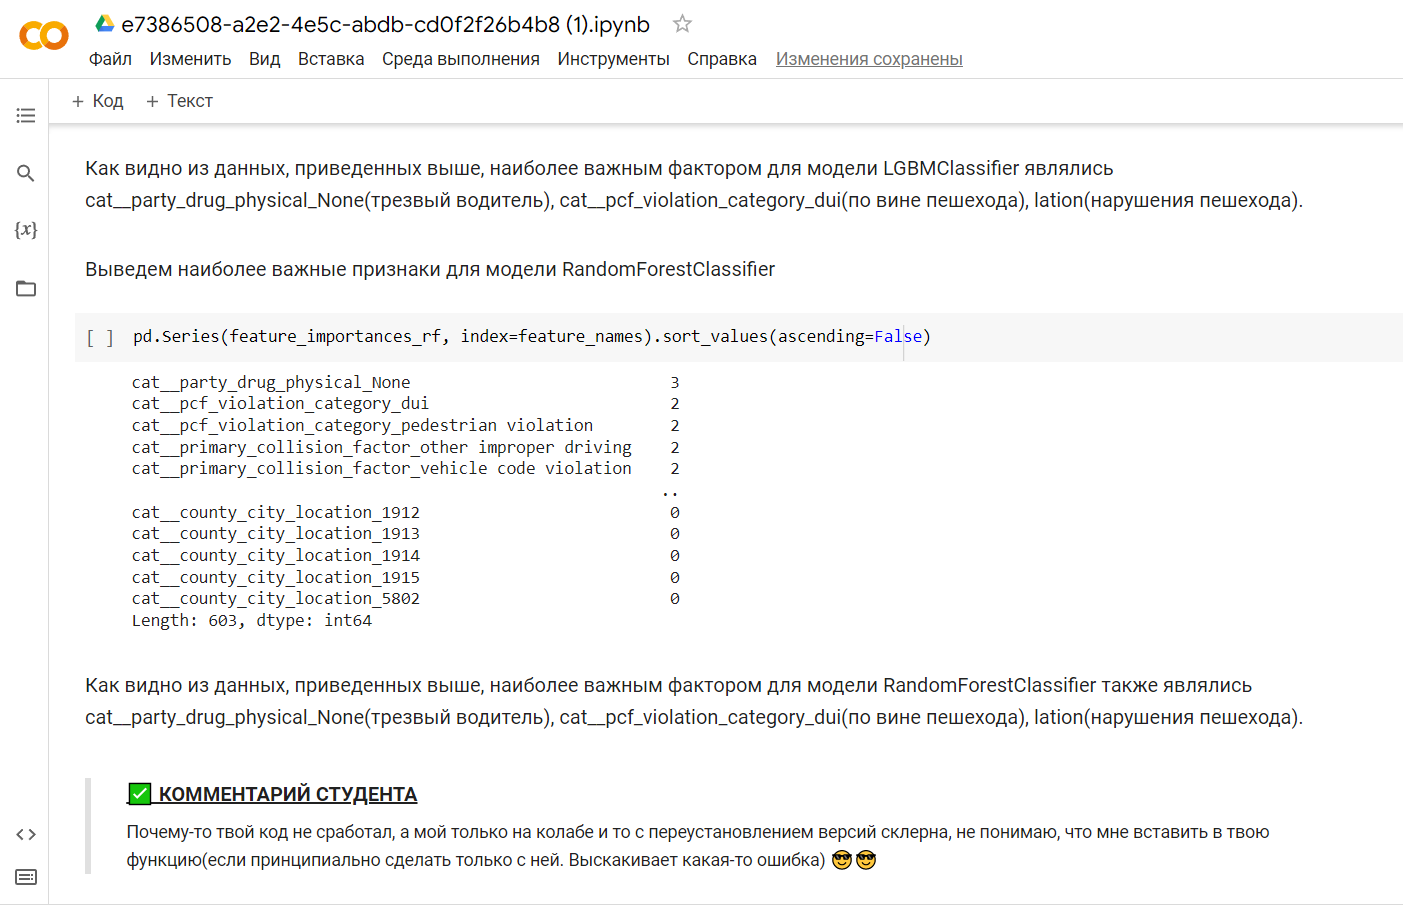

In [5]:
from IPython.display import Image
Image(filename='2022-07-09_10-58-04.png')

In [ ]:
# pd.Series(feature_importances_rf, index=feature_names).sort_values(ascending=False)

In [ ]:
# def cf_matrix(true, prediction):

#     cf_matrix = confusion_matrix(y_test, predictions_rfc[1])

#     group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']

#     group_counts = ['{0:0.0f}'.format(value) for value in
#                     cf_matrix.flatten()]

#     group_percentages = ['{0:.2%}'.format(value) for value in
#                          cf_matrix.flatten()/np.sum(cf_matrix)]

#     labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
#               zip(group_names, group_counts, group_percentages)]

#     labels = np.asarray(labels).reshape(2, 2)
#     sns.heatmap(cf_matrix, fmt='', cmap='Blues', ax=ax,
#                 annot=labels, annot_kws={'size': 16})

#     set_title('Матрица ошибок')

In [ ]:
# X_ohe = pd.get_dummies(X_test)
# X_ohe.columns


# scaler = StandardScaler()
# scaler.fit(X_ohe)

# X_test = pd.DataFrame(data=scaler.transform(X_ohe), columns=X_ohe.columns)
# X_test
# # pd.options.mode.chained_assignment = None

In [ ]:
# import seaborn as sns
# def chart_feature_imp(model):
#     feature_imp = pd.Series(model.feature_importances_, index=X_test)#.sort_values(by = ascending=False))

#     plt.gcf().set_size_inches(10, 6)
#     plt.rcParams.update({'font.size': 14})
    
#     ax = sns.barplot(x=feature_imp, y=feature_imp.index, orient='h')
#     _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
#     _ = ax.set_title('Визуализация важности признаков')

# chart_feature_imp(model_fitted_rfc[1].best_estimator_[1])

## Выводы
Таким образом, по результатам анализа данных, установлено, что лучшей моделью на accuracy показала себя RandomForestClassifier. При этом, в 30532 случаях модель RandomForestClassifier выдает истинно позитивное предсказание (True Positive), в 22 183 случаях модель выдает ошибочно положительное предсказание (False Positive).


При этом, наиболее важным фактором для модели RandomForestClassifier являлись факторы cat__party_drug_physical_None(трезвый водитель), cat__pcf_violation_category_dui(по вине пешехода), lation(нарушения пешехода). Из чего можно сделать вывод, что большинство аварий происходит по вине пешеходов. В данной связи можно было бы оборудовать автомобиль системой распознования пешехода (нейросеть, распознающая пешеходов и расстояния до него и автоматически тормозящая, без ведома водителя).